# Clustering and Classification Code
This document contains all code relevant to clustering and classification of the data, subsections 3 and 4 of the report.

## Clustering Code

In [1]:
import pandas as pd
import altair as alt
import numpy as np

In [2]:
clustering_df = pd.read_csv("./Datasets/KOF_World_Bank_merged.csv")
clustering_df['direction_bin'] = np.where(clustering_df['Pct Change'] > 0, 1, 0)
clustering_df['Index Direction'] = ['Up' if x == 1 else 'Down' for x in clustering_df['direction_bin']]
clustering_df = clustering_df.dropna()
clustering_df_nums = clustering_df.drop(['country', 'code', 'year', 'direction_bin', 'Index Direction'], axis=1)

from sklearn.preprocessing import StandardScaler

clustering_df_nums_scaled = pd.DataFrame(StandardScaler().fit_transform(clustering_df_nums), 
    columns=clustering_df_nums.columns)

In [3]:
from sklearn.decomposition import PCA

k_pca = 10
pca = PCA(n_components=k_pca)

pca_result = pca.fit_transform(clustering_df_nums_scaled)

pca_df = pd.DataFrame(pca_result, columns=[f'PC {i}' for i in range(1, k_pca + 1)])
pca_df['direction_bin'] = clustering_df['direction_bin']
pca_df['Index Direction'] = clustering_df['Index Direction']

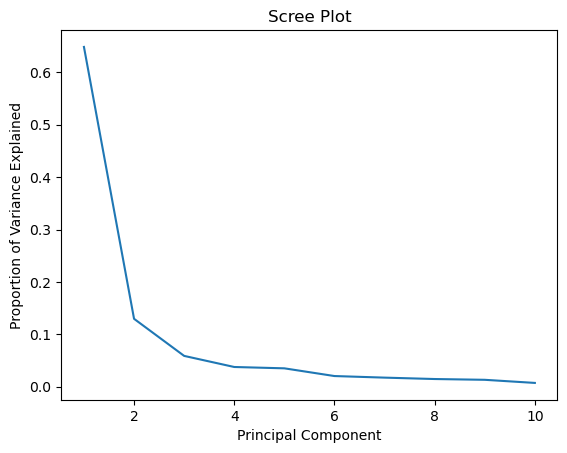

In [4]:
# Scree plot
import matplotlib.pyplot as plt

plt.plot(range(1, k_pca + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.show()

In [5]:
pc12 = alt.Chart(pca_df).mark_circle().encode(
    x='PC 1',
    y='PC 2',
    color='Index Direction:N'
)

pc23 = alt.Chart(pca_df).mark_circle().encode(
    x='PC 2',
    y='PC 3',
    color='Index Direction:N'
)

pc34 = alt.Chart(pca_df).mark_circle().encode(
    x='PC 3',
    y='PC 4',
    color='Index Direction:N'
)

alt.HConcatChart(hconcat=[pc12, pc23, pc34], title="PCA Visualizations")

alt.HConcatChart(...)

In [6]:
# Run Spectral Clustering on pca_df
from sklearn.mixture import GaussianMixture

pca_scaled = StandardScaler().fit_transform(pca_df.drop(['direction_bin', 'Index Direction'], axis=1))
pca_scaled_df = pd.DataFrame(pca_scaled, columns=pca_df.drop(['direction_bin', 'Index Direction'], axis=1).columns)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(pca_scaled_df)

pca_df['Index Direction'] = np.where(gmm.predict(pca_scaled_df)==1, "Up", "Down")

In [7]:
pc12_gmm = alt.Chart(pca_df).mark_circle().encode(
    x='PC 1',
    y='PC 2',
    color='Index Direction:N'
)

pc23_gmm = alt.Chart(pca_df).mark_circle().encode(
    x='PC 2',
    y='PC 3',
    color='Index Direction:N'
)

pc34_gmm = alt.Chart(pca_df).mark_circle().encode(
    x='PC 3',
    y='PC 4',
    color='Index Direction:N'
)

alt.HConcatChart(hconcat=[pc12_gmm, pc23_gmm, pc34_gmm], title="Gaussian Mixture Model via EM algorithm Clustering on PCA Data")

alt.HConcatChart(...)

/Users/andrew/anaconda3/envs/dsl/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


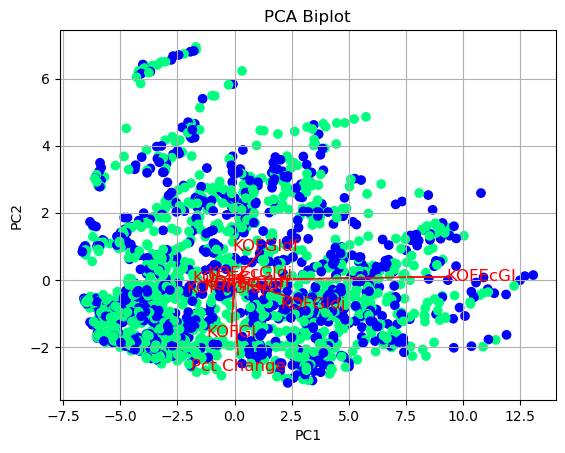

In [8]:
# Code to make a biplot
# Adapted from: https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot 
import matplotlib.pyplot as plt
x = clustering_df_nums_scaled.values
y = clustering_df['direction_bin'].values

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y, cmap='winter', label=["Up", "Down"]) #without scaling
    for i in range(n):
        plt.arrow(0, 0, 10*coeff[i,0], 10*coeff[i,1],color = 'r',alpha = 0.9)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(10*coeff[i,0]* 1.15, 10*coeff[i,1] * 1.15, labels[i], color = 'red', ha = 'center', va = 'center', fontsize='large')
    

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
plt.title("PCA Biplot")

myplot(pca.transform(x), pca.components_, labels=clustering_df_nums.columns) 
plt.show()


In [9]:
# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

tsne_obj = tsne.fit_transform(clustering_df_nums_scaled)

tsne_df = pd.DataFrame({'X': tsne_obj[:, 0], 'Y': tsne_obj[:, 1], 'Index Direction': clustering_df['Index Direction']})

In [10]:
tsne_graph = alt.Chart(tsne_df).mark_circle().encode(
    x='X',
    y='Y',
    color='Index Direction:N',
    tooltip=['X', 'Y']
).properties(
    title='t-SNE Visualization'
)
tsne_graph

alt.Chart(...)

In [11]:
# Run spectral clustering on tsne_df
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

tsne_scaled = StandardScaler().fit_transform(tsne_df.drop(['Index Direction'], axis=1))
tsne_scaled_df = pd.DataFrame(tsne_scaled, columns=tsne_df.drop(['Index Direction'], axis=1).columns)

tsne_spectral = SpectralClustering(n_clusters=2, random_state=0, affinity='nearest_neighbors')
tsne_spectral.fit(tsne_scaled_df)

tsne_df['cluster_spectral'] = np.where(tsne_spectral.labels_ == 1, "Up", "Down")

# Run GMM on tsne_df

tsne_gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
tsne_gmm.fit(tsne_scaled_df)

tsne_df['cluster_gmm'] = np.where(tsne_gmm.predict(tsne_scaled_df) == 1, "Up", "Down")

# Run Hierarchical Clustering on tsne_df

tsne_hierarchical = AgglomerativeClustering(n_clusters=2)
tsne_hierarchical.fit(tsne_scaled_df)

tsne_df['cluster_hierarchical'] = np.where(tsne_hierarchical.labels_ == 1, "Up", "Down")

/Users/andrew/anaconda3/envs/dsl/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [12]:
# TSNE: Compare clusterings to actual plot
tsne_graph_spectral = alt.Chart(tsne_df).mark_circle().encode(
    x='X',
    y='Y',
    color='cluster_spectral:N',
    tooltip=['X', 'Y']
).properties(
    title='Spectral Clustering on t-SNE Data'
)

tsne_graph_gmm = alt.Chart(tsne_df).mark_circle().encode(
    x='X',
    y='Y',
    color='cluster_gmm:N',
    tooltip=['X', 'Y']
).properties(
    title='Gaussian Mixture Model via EM algorithm Clustering on t-SNE Data'
)

tsne_graph_hierarchical = alt.Chart(tsne_df).mark_circle().encode(
    x='X',
    y='Y',
    color=alt.Color('cluster_hierarchical:N', legend=None),
    tooltip=['X', 'Y']
).properties(
    title='Hierarchical Clustering on t-SNE Data'
)

tsne_comparison = alt.HConcatChart(hconcat=[tsne_graph, tsne_graph_spectral], title="Comparison of original data to various clustering algorithms on t-SNE data")
tsne_comparison &= tsne_graph_gmm | tsne_graph_hierarchical

tsne_comparison

alt.VConcatChart(...)

In [13]:
# UMAP
import umap

umap_obj = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation', random_state=0)
umap_obj.fit(clustering_df_nums_scaled)

umap_df = pd.DataFrame({'X': umap_obj.embedding_[:, 0], 'Y': umap_obj.embedding_[:, 1], 'Index Direction': clustering_df['Index Direction']})

/Users/andrew/anaconda3/envs/dsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrew/anaconda3/envs/dsl/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [14]:
umap_original_graph = alt.Chart(umap_df).mark_circle().encode(
    x='X',
    y='Y',
    color='Index Direction:N',
    tooltip=['Index Direction']
).properties(
    title="UMAP Visualization"
)

umap_original_graph

alt.Chart(...)

In [15]:
# Run spectral clustering on umap_df

umap_scaled = StandardScaler().fit_transform(umap_df.drop(['Index Direction'], axis=1))
umap_scaled_df = pd.DataFrame(umap_scaled, columns=umap_df.drop(['Index Direction'], axis=1).columns)

umap_spectral = SpectralClustering(n_clusters=2, random_state=0, affinity='nearest_neighbors')
umap_spectral.fit(umap_scaled_df)

umap_df['cluster_spectral'] = np.where(umap_spectral.labels_ == 1, "Up", "Down")

# Run GMM on umap_df

umap_gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
umap_gmm.fit(umap_scaled_df)

umap_df['cluster_gmm'] = np.where(umap_gmm.predict(umap_scaled_df) == 1, "Up", "Down")

# Run Hierarchical Clustering on umap_df

umap_hierarchical = AgglomerativeClustering(n_clusters=2)
umap_hierarchical.fit(umap_scaled_df)

umap_df['cluster_hierarchical'] = np.where(umap_hierarchical.labels_ == 1, "Up", "Down")

/Users/andrew/anaconda3/envs/dsl/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [16]:
umap_graph_spectral = alt.Chart(umap_df).mark_circle().encode(
    x='X',
    y='Y',
    color='cluster_spectral:N',
    tooltip=['X', 'Y']
).properties(
    title='Spectral Clustering on UMAP Data'
)

umap_graph_gmm = alt.Chart(umap_df).mark_circle().encode(
    x='X',
    y='Y',
    color='cluster_gmm:N',
    tooltip=['X', 'Y']
).properties(
    title='Gaussian Mixture Model via EM algorithm Clustering on UMAP Data'
)

umap_graph_hierarchical = alt.Chart(umap_df).mark_circle().encode(
    x='X',
    y='Y',
    color=alt.Color('cluster_hierarchical:N', legend=None),
    tooltip=['X', 'Y']
).properties(
    title='Hierarchical Clustering on UMAP Data'
)

umap_comparison = alt.HConcatChart(hconcat=[umap_original_graph, umap_graph_spectral], title="UMAP Visualization compared to Spectral Clustering on UMAP Data")
umap_comparison &= umap_graph_gmm | umap_graph_hierarchical
umap_comparison

alt.VConcatChart(...)

In [17]:
alt.HConcatChart(hconcat=[tsne_graph, umap_original_graph], title="t-SNE and UMAP Visualizations")

alt.HConcatChart(...)

In [18]:
# Run KNN on tsne_df
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

X = tsne_df.drop(['Index Direction', 'cluster_spectral', 'cluster_gmm', 'cluster_hierarchical'], axis=1)
y = tsne_df['Index Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

cv_knn_tsne = cross_val_score(knn, X, y, cv=10)
print(f"kNN accuracy on t-SNE data: {cv_knn_tsne.mean()} with std {cv_knn_tsne.std()}")

kNN accuracy on t-SNE data: 0.7959272526866906 with std 0.04331902568289351


In [19]:
# Run KNN on umap_df
X = umap_df.drop(['Index Direction', 'cluster_spectral', 'cluster_gmm', 'cluster_hierarchical'], axis=1)
y = umap_df['Index Direction']

knn = KNeighborsClassifier(n_neighbors=1)
cv_knn_umap = cross_val_score(knn, X, y, cv=10)
print(f"kNN accuracy on UMAP data: {cv_knn_umap.mean()} with std {cv_knn_umap.std()}")

kNN accuracy on UMAP data: 0.749151281344723 with std 0.04968690001421213


These kNN models were tested near the date of submission, and despite the fact that they outperform our other classification models, even after cross-validating, they were not included due to concerns over their validity. Due to the fact that they are 1NN models, and the t-SNE based one is subject to randomness from the t-SNE algorithm, we did not feel comfortable including them in the final report as we were not confident in interpreting them. However, we included this code here for the sake of completeness.

## Classification Code

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

wb_df = pd.read_csv("./Datasets/KOF_World_Bank_merged.csv")

# Data consisting of only KOF Index data
classification_df = wb_df.copy()[['code', 'year', 'KOFFiGIdf', 'KOFFiGIdj', 'Pct Change']]
classification_df['direction_bin'] = np.where(classification_df['Pct Change'] > 0, 1, 0)

classification_df['US_pct_change'] = wb_df['year'].map(wb_df[wb_df['code'] == 'USA'].groupby(by='year')['Pct Change'].first())
classification_df['US_FIdj'] = wb_df['year'].map(wb_df[wb_df['code'] == 'USA'].groupby(by='year')['KOFFiGIdj'].first())
classification_df['US_FIdf'] = wb_df['year'].map(wb_df[wb_df['code'] == 'USA'].groupby(by='year')['KOFFiGIdf'].first())

X = classification_df[classification_df['code'] != 'USA'].drop(['code', 'year', 'Pct Change', 'direction_bin'], axis=1)
y = classification_df[classification_df['code'] != 'USA']['direction_bin'].values

In [21]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train)
cv_logreg = cross_val_score(logreg, X, y, cv=10)
print(f"Logistic Regression model: {cv_logreg.mean():.3f} accuracy with a standard deviation of {cv_logreg.std():.3f}")

Logistic Regression model: 0.676 accuracy with a standard deviation of 0.110


In [22]:
# SVM Model
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0)
svm.fit(X_train, y_train)

cv_svm = cross_val_score(svm, X, y, cv=10)
print(f"SVM model: {cv_svm.mean():.3f} accuracy with a standard deviation of {cv_svm.std():.3f}")

SVM model: 0.683 accuracy with a standard deviation of 0.111


In [23]:
# Grid search for MLP (Neural Network)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'hidden_layer_sizes': [(100, 100, 80, 50), (100, 80, 50), (100, 50), (100), (80, 50), (50)]}

nn_grid = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, refit=True)
nn_grid.fit(X_train, y_train)

GridSearchCV(estimator=MLPClassifier(max_iter=10000),
             param_grid={'hidden_layer_sizes': [(100, 100, 80, 50),
                                                (100, 80, 50), (100, 50), 100,
                                                (80, 50), 50]})

In [24]:
nn_grid.best_params_

{'hidden_layer_sizes': (100, 80, 50)}

In [25]:
nn_model = MLPClassifier(hidden_layer_sizes=(100, 100, 80, 50), max_iter=10000, random_state=0)
cv_nn = cross_val_score(nn_model, X, y, cv=10)
print(f"Neural Network model: {cv_nn.mean():.3f} accuracy with a standard deviation of {cv_nn.std():.3f}")

Neural Network model: 0.683 accuracy with a standard deviation of 0.093


In [26]:
# Naive Bayes Model
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
cv_nb = cross_val_score(nb, X, y, cv=10)

print(f"Naive Bayes model: {cv_nb.mean():.3f} accuracy with a standard deviation of {cv_nb.std():.3f}")

Naive Bayes model: 0.698 accuracy with a standard deviation of 0.115


In [27]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=1, random_state=0, n_estimators=200)
cv_rf = cross_val_score(rf, X, y, cv=10)

print(f"Random Forest model: {cv_rf.mean():.3f} accuracy with a standard deviation of {cv_rf.std():.3f}")

Random Forest model: 0.740 accuracy with a standard deviation of 0.126
